# Наша первая свёрточная нейросеть 

Пришло время построить нашу первую свёрточную нейросеть. Будем использовать для этого датасет [MNIST.](https://www.cs.toronto.edu/~kriz/cifar.html) Набор данных включает в себя изображения рукописных цифр.  

<img src="https://cdn-images-1.medium.com/max/1600/1*Riqqoa7vKHXnFHvaGfDFjA.png" style="width:90%">

In [2]:
# подгружаем пакеты
import numpy as np
import random
from tqdm import tqdm

import keras
from keras import backend as K

%matplotlib inline
import matplotlib.pyplot as plt

## 1. Смотрим на данные 

Скачаеми приготовим данные. Буквально через минуту в наших руках окажутся $60 000$ картинок размера $28 \times 28$.

In [3]:
from keras.datasets import mnist
(x_tr, y_tr), (x_ts, y_ts) = mnist.load_data()

In [4]:
print("Train samples:", x_tr.shape, y_tr.shape)
print("Test samples:", x_ts.shape, y_ts.shape)

Train samples: (60000, 28, 28) (60000,)
Test samples: (10000, 28, 28) (10000,)


Нарисуем несколько рандомных картинок из тренировочной выборки. 

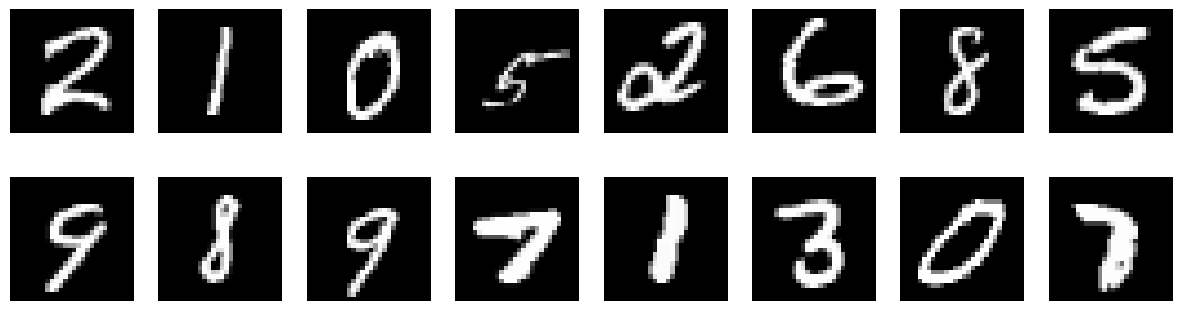

In [5]:
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_tr))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_tr[random_index, :], cmap = 'gray')
plt.show()

Отлично! Как вы помните, если пронормаровать данные, то сетка будет сходиться на порядок быстрее. 

Также, как вы помните из предыдущих скриптов, картинка - это тензор из циферок. Каждая циферка сообщает нам о яркости конкретного пикселя. Яркость измеряется по шкале от 0 до 255. В связи с этим фактом, нормализация будет немного странной: 

$$
x_{norm} = \frac{x}{255}
$$

In [6]:
# делай раз
x_train = x_tr/255
x_test =  x_ts/255

# Оставляем одну размерность на число каналов
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))     

Также мы помним, что классы нужно конвертировать одним горячи кодированием (one-hot encoding) в набор из дамми-переменных. 

```
0 → [1, 0, 0, 0, 0, 0, 0, 0, 0]
1 → [0, 1, 0, 0, 0, 0, 0, 0, 0]
2 → [0, 0, 1, 0, 0, 0, 0, 0, 0]
3 → [0, 0, 0, 1, 0, 0, 0, 0, 0]
etc...
```

In [7]:
# делай два! 
y_train = keras.utils.to_categorical(y_tr,10)
y_test = keras.utils.to_categorical(y_ts,10)

# Размерность после конвертации будет вот такой: (?, NUM_CLASSES)
y_test

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [8]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


## 2.  Выбираем для нашей нейросети архитектуру

Свёрточная нейронная сеть строится из нескольких разных типов слоёв: 

* [Conv2D](https://keras.io/layers/convolutional/#conv2d) - Конволюция:
    - **filters**: число выходных каналов; 
    - **kernel_size**: размер окна для свёртки;
    - **padding**: padding="same" добавляет нулевую каёмку по краям картинки, чтбы после свёртки размеры картинки не изменялись; padding='valid' ничего не добавляет;
    - **activation**: "relu", "tanh", etc.
    - **input_shape**: размер входа
* [MaxPooling2D](https://keras.io/layers/pooling/#maxpooling2d) - макспулинг
* [Flatten](https://keras.io/layers/core/#flatten) - разворачивает картинку в вектор 
* [Dense](https://keras.io/layers/core/#dense) - полносвязный слой (fully-connected layer)
* [Activation](https://keras.io/layers/core/#activation) - функция активации
* [LeakyReLU](https://keras.io/layers/advanced-activations/#leakyrelu) - leaky relu активация
* [Dropout](https://keras.io/layers/core/#dropout) - дропаут.


В модели, которую мы определим ниже, на вход будет идти тензоры размера __(None, 28, 28, 1)__ и __(None, 10)__. На выходе мы будем получать вероятноть того, что объект относится к конкретному классу. Разменость __None__ заготовлена для размерности батча. 

In [9]:
# подгружаем важные строительные блоки
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, InputLayer, LeakyReLU, Input

### 2.1 Полносвязная сетка 

Соберём двухслойную полносвязную сетку: 

* Вход
* Развернём картинку в вектор 
* Полносвязный слой с 64 нейронами
* RELU 
* Полносвязный слой с 32 нейронами 
* Dropout с вероятностью 0.5 
* RELU 
* Полносвязный слой с 16 нейронами 
* Dropout с вероятностью 0.5 
* RELU 
* Слой с 10 нейронами для клссов, в качестве активации используйте Softmax

In [10]:
model_1 = Sequential( )

# 1. Добавляем входной слой с указанной формой входных данных
model_1.add(Input(shape=(28, 28)))  # Задаём форму входных данных через Input

# 2. Первый полносвязный слой с 64 нейронами и функцией активации ReLU
model_1.add(Flatten())  # Разворачиваем входное изображение в вектор
model_1.add(Dense(64))
model_1.add(Activation('relu'))

# 3. Второй полносвязный слой с 32 нейронами и функцией активации ReLU
model_1.add(Dense(32))
model_1.add(Dropout(0.5))  # Dropout с вероятностью 0.5 для регуляризации
model_1.add(Activation('relu'))

# 4. Третий полносвязный слой с 16 нейронами и функцией активации ReLU
model_1.add(Dense(16))
model_1.add(Dropout(0.5))  # Dropout с вероятностью 0.5 для регуляризации
model_1.add(Activation('relu'))

# 5. Выходной слой с 10 нейронами (для классификации на 10 классов) и функцией активации Softmax
model_1.add(Dense(10))
model_1.add(Activation('softmax'))

model_1.compile("adam", "categorical_crossentropy", metrics=["accuracy"])

In [11]:
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          50,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             170 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 10)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 53,018 (207.10 KB)

 Trainable params: 53,018 (207.10 KB)

 Non-trainable params: 0 (0.00 B)

Можно визуализировать внутренними средствами keras сетку, которую мы собираем. 

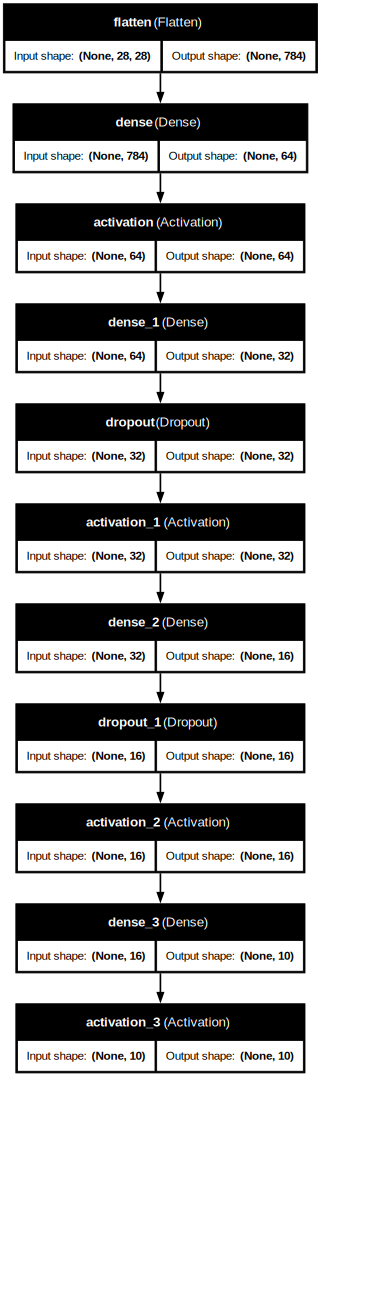

In [12]:
from IPython.display import SVG
from keras.utils import model_to_dot

SVG(model_to_dot(model_1, show_shapes=True, dpi=60).create(prog='dot', format='svg'))

In [14]:
# обучаем 5 эпох
hist = model_1.fit(x_train, y_train, validation_split=0.2, epochs=5, verbose=1)

Epoch 1/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.4364 - loss: 1.5832 - val_accuracy: 0.9202 - val_loss: 0.4038
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7256 - loss: 0.8545 - val_accuracy: 0.9391 - val_loss: 0.2817
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7768 - loss: 0.7073 - val_accuracy: 0.9490 - val_loss: 0.2270
Epoch 4/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8016 - loss: 0.6395 - val_accuracy: 0.9555 - val_loss: 0.2025
Epoch 5/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8178 - loss: 0.5896 - val_accuracy: 0.9560 - val_loss: 0.2100


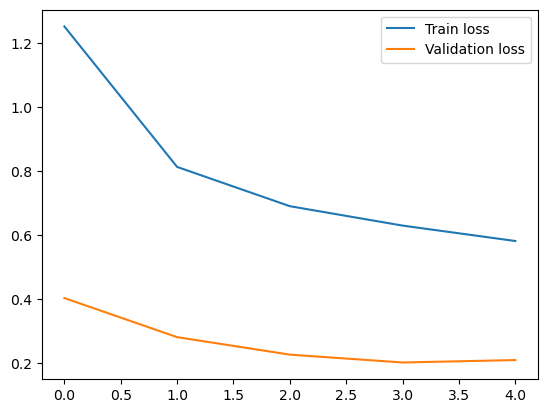

In [15]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['Train loss', 'Validation loss'])

In [16]:
print("\nLoss, Accuracy = ", model_1.evaluate(x_test, y_test))

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9520 - loss: 0.2394

Loss, Accuracy =  [0.2147352546453476, 0.9567999839782715]


* Посмотрите на качество получившейся модели. Вернитесь по коду вверх и раскоментируйте строки, где картинки нормируются к отрезку $[0;1]$. Переобучите сетку. Что произошло с качеством? 
* Теперь попробуйте использовать в качестве функции активации линейную функцию. Что произошло с качеством модели?  

Можно посмотреть, где именно сетка ошибается. 

In [42]:
y_pred = model_1.predict(x_test)
y_pred_classes = y_pred.argmax(axis=1)

errors =  y_pred_classes != y_ts

x_err = x_ts[errors]
y_err = y_ts[errors]
y_pred = y_pred_classes[errors]

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


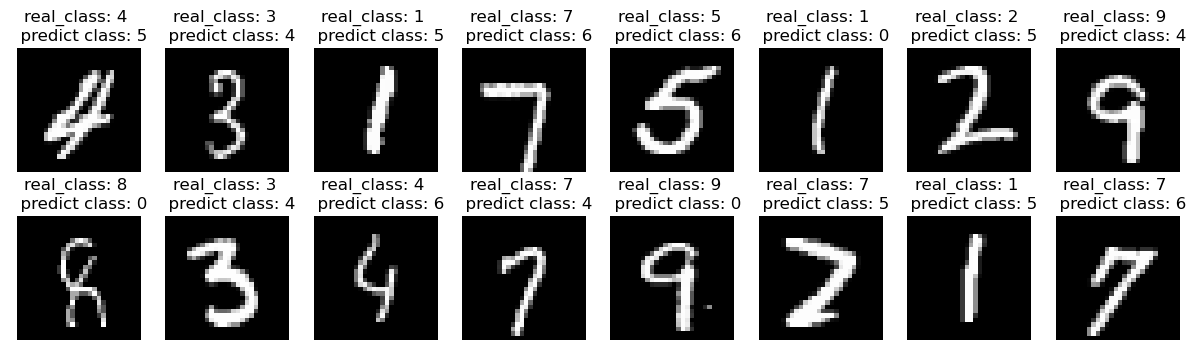

In [43]:
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_err))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_err[random_index, : ], cmap='gray')
        ax.set_title('real_class: {} \n  predict class: {}'.format(y_err[random_index], y_pred[random_index]))
plt.show()

### 2.2 Свёрточная сетка 

Теперь давайте соберём свёртоную сеть: 

* Свёртка с ядром $5 \times 5$, same padding и $32$ каналами
* ReLU
* Макспулинг размера $2 \times 2$
* Свёртка с ядром $5 \times 5$ и $16$ каналами  и same padding
* ReLU
* Макспулинг размера $2 \times 2$ с шагом (strides) $2$ по обеим осям 
* Дальше используйте старую архитектуру 

In [32]:
model_2 = Sequential( )

# Входной слой с указанием формы входных данных
model_2.add(InputLayer(shape=(28, 28, 1)))

# Первый свёрточный слой с ядром 5x5, 32 каналами, активацией ReLU и same padding
model_2.add(Conv2D(32, (5, 5), padding='same'))
model_2.add(Activation('relu'))

# Макспулинг 2x2
model_2.add(MaxPooling2D(pool_size=(2, 2)))

# Второй свёрточный слой с ядром 5x5, 16 каналами, активацией ReLU и same padding
model_2.add(Conv2D(16, (5, 5), padding='same'))
model_2.add(Activation('relu'))

# Макспулинг 2x2 с шагом 2 по обеим осям
model_2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Разворачиваем вектор для полносвязных слоев
model_2.add(Flatten())

# Полносвязный слой с 64 нейронами и активацией ReLU
model_2.add(Dense(64))
model_2.add(Activation('relu'))

# Полносвязный слой с 32 нейронами и активацией ReLU
model_2.add(Dense(32))
model_2.add(Activation('relu'))

# Полносвязный слой с 16 нейронами и активацией ReLU
model_2.add(Dense(16))
model_2.add(Activation('relu'))

# Выходной слой для 10 классов с активацией softmax
model_2.add(Dense(10))
model_2.add(Activation('softmax'))

model_2.compile("adam", "categorical_crossentropy", metrics=["accuracy"])

In [48]:
model_2 = Sequential()

# Входной слой с уменьшением числа фильтров
model_2.add(InputLayer(shape=(28, 28, 1)))
model_2.add(Conv2D(16, (3, 3), padding='same'))
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

# Уменьшаем количество фильтров во втором слое
model_2.add(Conv2D(8, (3, 3), padding='same'))
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Уменьшаем число нейронов в полносвязных слоях
model_2.add(Flatten())
model_2.add(Dense(32))
model_2.add(Activation('relu'))
model_2.add(Dense(16))
model_2.add(Activation('relu'))

# Выходной слой с 10 классами
model_2.add(Dense(10))
model_2.add(Activation('softmax'))

# Компиляция модели
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [49]:
model_2.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 28, 28, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_22 (Activation)           │ (None, 28, 28, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 14, 14, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 14, 14, 8)           │           1,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_23 (Activation)           │ (None, 14, 14, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 7, 7, 8)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 392)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 32)                  │          12,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_24 (Activation)           │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_25 (Activation)           │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 10)                  │             170 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_26 (Activation)           │ (None, 10)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,594 (57.01 KB)

 Trainable params: 14,594 (57.01 KB)

 Non-trainable params: 0 (0.00 B)

In [51]:
# обучаем 5 эпох
# hist = model_2.fit(x_train, y_train, validation_split=0.2, epochs=5, verbose=1)

from keras.callbacks import EarlyStopping

# Обучение на большем числе эпох, с ранней остановкой
early_stopping_monitor = EarlyStopping(patience=5, restore_best_weights=True)
hist = model_2.fit(x_train, y_train, epochs=30, batch_size=32, validation_split=0.2, callbacks=[early_stopping_monitor])

Epoch 1/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.7611 - loss: 0.7332 - val_accuracy: 0.9593 - val_loss: 0.1340
Epoch 2/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9602 - loss: 0.1302 - val_accuracy: 0.9665 - val_loss: 0.1053
Epoch 3/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9716 - loss: 0.0955 - val_accuracy: 0.9769 - val_loss: 0.0775
Epoch 4/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9766 - loss: 0.0741 - val_accuracy: 0.9772 - val_loss: 0.0788
Epoch 5/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9799 - loss: 0.0632 - val_accuracy: 0.9804 - val_loss: 0.0644
Epoch 6/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9823 - loss: 0.0578 - val_accuracy: 0.9790 - val_loss: 0.0741
Epoch 7/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9837 - loss: 0.0514 - val_accuracy: 0.9790 - val_loss: 0.0670
Epoch 8/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9860 - loss: 0

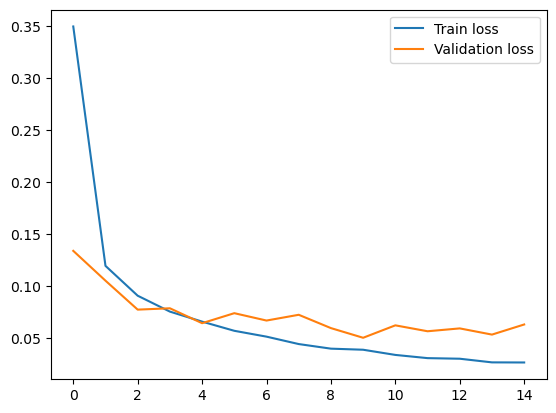

In [52]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['Train loss', 'Validation loss'])

In [53]:
print("\nLoss, Accuracy = ", model_2.evaluate(x_test, y_test))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9858 - loss: 0.0517

Loss, Accuracy =  [0.040652498602867126, 0.9890000224113464]


Как видите, точность довольно сильно подскочила. Попробуйте поиграться числом параметров и слоёв так, чтобы их стало меньше, а качество сетки стало лучше. Попробуйте обучать нейросетку большее количество эпох. 

Снова посмотрим на ошибки. 

In [64]:
y_pred = model_2.predict(x_test)
y_pred_classes = y_pred.argmax(axis=1)

errors =  y_pred_classes != y_ts

x_err = x_ts[errors]
y_err = y_ts[errors]
y_pred = y_pred_classes[errors]

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


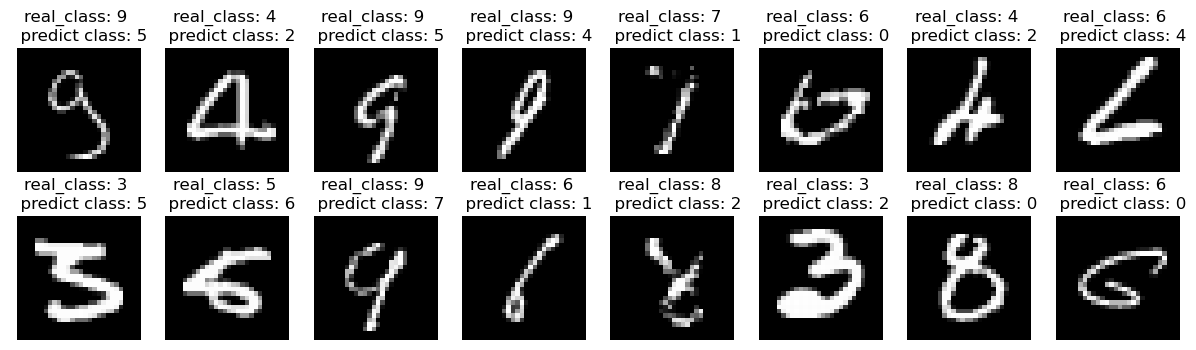

In [65]:
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_err))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_err[random_index, : ], cmap='gray')
        ax.set_title('real_class: {} \n  predict class: {}'.format(y_err[random_index], y_pred[random_index]))
plt.show()